# Active metasurface simulation

In this notebook we show how to calculate the dispersion and properties of an active metasurface, i.e. sustaining an excitonic response. Excitons are electron-hole buond states that interact with light. If the interaction strength overcomes the photonic and excitonic losses, a new excited state is formed: the polariton.

In [1]:
import sys
sys.path.append('/home/simone/data')
import legume
from legume import viz
import numpy as np
import matplotlib.pyplot as plt
print(f"legume version: {legume.__version__}")

legume version: 1.0.1


## Photonic structure simulation

As an example, we take a pervoskite-based metasurfaced recently studied, see N.H.M. Dang et al., Advance Optical Materials (2020). It consist of a SiO$_2$ core with etched air holes where a pervoskite material (PEPI) is inflitrated. The PEPI is the active material that sustains excitonic states. A residual PEPI layer lies on top of the etched region. Finally, the device is encapsulated with a polymer (PMMA) layer as depicted in the figure.

![](img/PEPI_white.png)

We start by defining the structure and calculating the purely photonic properties. We start by defining the main structural parameters.

In [2]:
# lattice constant [nm]
a = 330    
# Thicknesses of all layers 
t_PMMA,t_PEPI,t_etch = 200/a, 30/a, 170/a 
# Permettivity of all materials
eps_SiO2,eps_PEPI,eps_PMMA = 1.48**2,2.4**2 ,1.49**2  
r = 0.2  # radius
gmax=6.1

In the first calculations round, we just the purely photonics properties. To do so, we initialize the photonic crystal slab.

In [3]:
lattice_type = 'square'
lattice = legume.Lattice(lattice_type)

phc = legume.PhotCryst(lattice,eps_l=eps_SiO2)

phc.add_layer(d=t_etch, eps_b=eps_SiO2)
phc.add_layer(d=t_PEPI, eps_b=eps_PEPI)
phc.add_layer(d=t_PMMA, eps_b=eps_PMMA)

phc.layers[-3].add_shape(legume.Circle(eps=eps_PEPI, r=r))

To better compare with experimental data, we calculate the dispersion in the same wavevector range as in the paper: $k\in[-4,4]\mu\text{m}^{-1}$. In `legume` notation, wavevectors are in units of $k_{\text{leg}}=ka$, with $k$ and $a$ the wavevector and the lattice constant in [m]

In [4]:
k_dim_max = 4 # um^-1
k_max = k_dim_max*a/1000   # Dimensionless maximum wavevector
num_k = 30
path = lattice.bz_path([[-k_max,1e-15],"G",[k_max,0]],[num_k])
gme_options = {'gmode_inds':[0,1,2,3],
        'numeig':8,
        'verbose':True}
gme = legume.GuidedModeExp(phc,gmax=gmax)
gme.run(kpoints=path['kpoints'],**gme_options)

19.610s total time for real part of frequencies, of which
  12.084s (62%) for guided modes computation using the gmode_compute='exact' method
  0.002s (0%) for inverse matrix of Fourier-space permittivity
  0.828s (4%) for matrix diagionalization using the 'eigh' solver
  6.666s (34%) for creating GME matrix
4.344s for imaginary part computation


(2.0, 2.6)

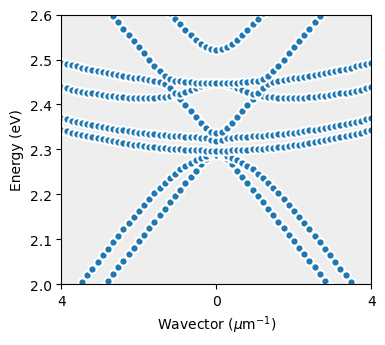

In [5]:
fig, ax = plt.subplots(1, figsize = (4, 3.5))
legume.viz.bands(gme,ax=ax,a=a*1e-9,eV=True)
ax.set_xticks(path['indexes'])
ax.set_xticklabels([f"{k_dim_max}","0",f"{k_dim_max}"])
ax.set_xlabel("Wavector ($\\mu$m$^{-1}$)")
ax.set_ylim(2,2.6)

These bands won't compare well with experimental data since the the excitation light is s-(TE) polarized. For a direct comparison, we recalculate only the odd modes with respect the vertical plane of symmetry. Under the diffraction limit, these modes correspond to the one excited by an s-polarized pump.

In [6]:
gme_options = {'gmode_inds':[0,1,2,3],
        'numeig':8,
        'verbose':True,
        'kz_symmetry': "odd",
        'angles':path['angles']}
gme.run(kpoints=path['kpoints'],**gme_options)

20.117s total time for real part of frequencies, of which
  12.320s (61%) for guided modes computation using the gmode_compute='exact' method
  0.000s (0%) for inverse matrix of Fourier-space permittivity
  0.273s (1%) for matrix diagionalization using the 'eigh' solver
  6.516s (32%) for creating GME matrix
  0.975s (5%) for creating change of basis matrix and multiply it using dense matrices
5.277s for imaginary part computation


(2.0, 2.6)

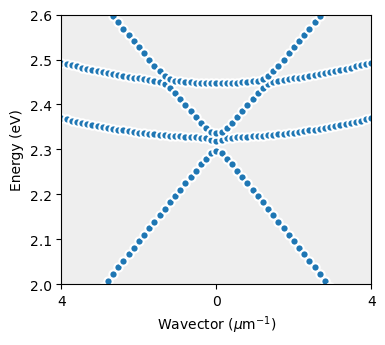

In [7]:
fig, ax = plt.subplots(1, figsize = (4, 3.5))
legume.viz.bands(gme,ax=ax,a=a*1e-9,eV=True)
ax.set_xticks(path['indexes'])
ax.set_xticklabels([f"{k_dim_max}","0",f"{k_dim_max}"])
ax.set_xlabel("Wavector ($\\mu$m$^{-1}$)")
ax.set_ylim(2,2.6)

## Excitons in legume

Before delving into polaritonic simulations, it's essential to understand the foundational concept of excitons within the Legume code. Excitons are quasiparticles formed by bound electron-hole states. The binding energy of excitons can be notably influenced in systems where excitons experience confinement along a specific direction. Examples of such systems include semiconductor quantum wells, perovskites, or monolayers of transition metal dichalcogenides.

In the context of `legume`, excitons are treated as being perfectly confined within a 2D plane. The dynamics of excitons are calculated by solving the 2D Schrödinger equation. Analogous to how photons in periodically patterned Photonic Crystals (PhCs) feel a periodic potential, excitons also experience a periodic potential when the 2D layer is patterned.
For instance, holes etched in a quantum well layer act as barriers for the excitonic wavefunction. Conversely, a pillar of perovskite provides a potential well where excitons can exist. This potential alters the dispersion relation and the wavefunction of free excitons.

## Setting up ExcitonSchroedEq Simulation

To investigate the impact of a potential on excitonic eigenmodes, we initiate an `ExcitonSchroedEq` simulation.
We start by defining some excitonic parameters: the bare exciton energy $E_0$ epressed in eV, the excitonic mass $M$ in kg and the non-radiative losses of excitons ``loss`` in eV. For the mass, we can take a fraction of the free electron mass $m_e$ from `legume.constant` module. 

In [8]:
M = legume.constants.m_e*0.2
E0 = 2.394
loss = 5*10**-4 #[eV]

Before running the simulation, we have to specify few other parameters. Firsst of all, the `z`-position, determining the location of the 2D simulation. This will define the layer of the `phc` from which we `ShapesLayer` objects are taken, subsequently characterizing the in-plane potential. Each of these `ShapesLayer` objects is associated with a potential `V_shapes` with respect to a background at null potential. In the present example, we want to simulate PEPI pillars where excitons can dwell. Consequently, a negative (attractive) potential, `V_shapes`=-1, is configured to appropriately model this scenario.

In [9]:
exc_options = {'numeig_ex':8,
        'verbose_ex':True}
V = -1 # Negative potential for PEPI pillars
z = phc.layers[0].z_mid # center of the layer with pillar
exc_pill = legume.ExcitonSchroedEq(phc,z=z,V_shapes=V,a=a,M=M,E0=E0,loss= loss,\
                                gmax=gmax,truncate_g='abs')
exc_pill.run(kpoints=path["kpoints"], **exc_options)

0.0932s total time for real and imaginary energies, of which
  0.0527s for diagonalization of the Hamiltonian


We can begin by examining the real-space potential derived from the Fourier components employed in the computation, along with exploring the quantized excitonic bands. These bands are very flattened indicating excitonic modes extremely confined in the pillars.

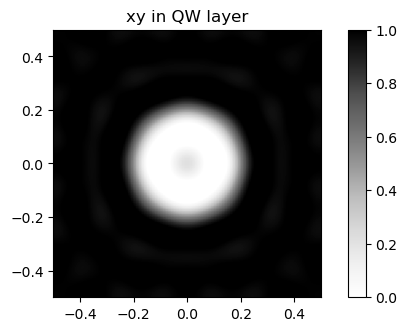

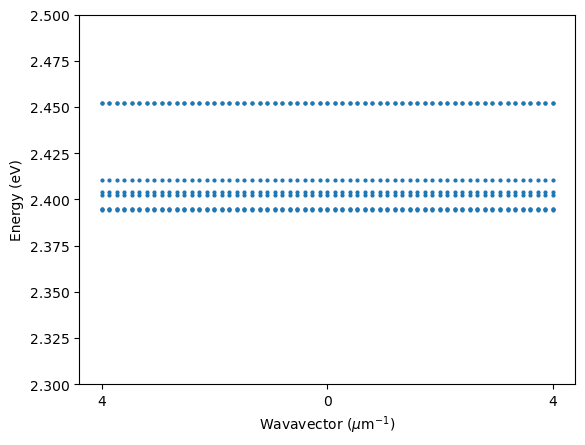

In [10]:
legume.viz.pot_ft(exc_pill)
plt.show()
fig,ax = plt.subplots()
for ind,e in enumerate(exc_pill.eners):
        ax.scatter([ind]*8,np.real(e) ,c="C0",s=4 )
ax.set_xticks(path['indexes'])
ax.set_xticklabels([f"{k_dim_max}","0",f"{k_dim_max}"])
ax.set_xlabel("Wavavector ($\\mu$m$^{-1}$)")
ax.set_ylabel("Energy (eV)")
ax.set_ylim(2.3,2.5)
plt.show()

Finally, we can exploit `viz.wavef` to plot the wavefunction of modes. Specifically, we plot the wavefunctions associated with the lowest and fourth bands.

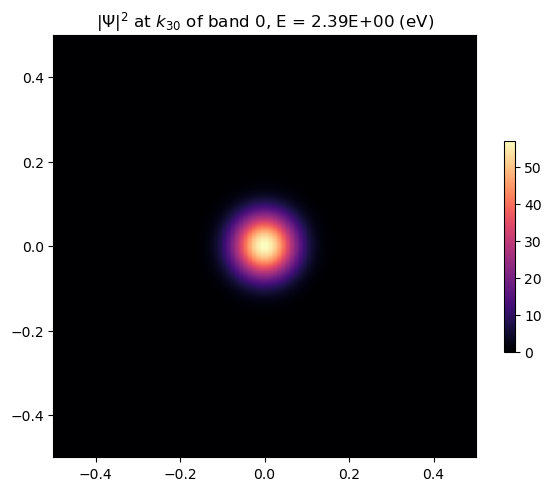

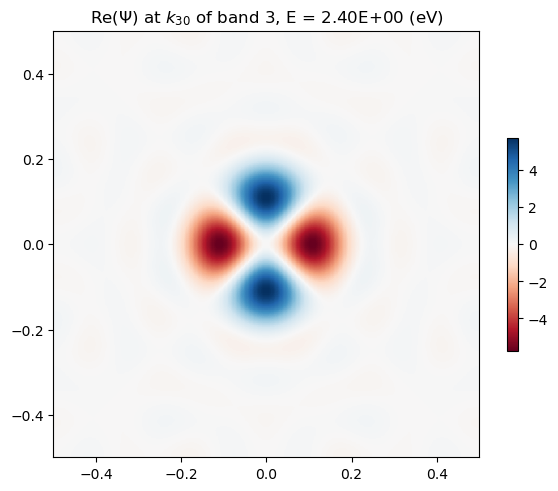

In [11]:
plot1 = legume.viz.wavef(exc_pill,
    kind=num_k,
    mind=0,
    val="abs2",
    cbar=True,)
plot2= legume.viz.wavef(exc_pill,
    kind=num_k,
    mind=3,
    val="re",
    cbar=True,)

## Polaritonic simulation

So far, we've computed the photonic and excitonic properties separately. Now, it's time to turn on light-matter interaction! Everything is handled by `legume`, all we need to do is to add 2D active layers to the `PhotCryst`. We can do that with the `add_qw` method. Additionally to what we did with the `ExcitonSchroedEq` simulation, here we have to provide the vecotrial oscillator strength in the excitonic resonance in the $[x,y,z]$ frame of reference. For each $z$-position, we place two active well layers with either purely $\hat{x}$- and $\hat{y}$-polarized.

In [12]:
osc_str_x = 2*10**19*np.array([1,0,0]) # Oscillator strength per unit per unit surface [m^-2]
osc_str_y = 2*10**19*np.array([0,1,0])

# Biuld the PhC
phc = legume.PhotCryst(lattice,eps_l=eps_SiO2)
phc.add_layer(d=t_etch, eps_b=eps_SiO2)
phc.add_layer(d=t_PEPI, eps_b=eps_PEPI)
phc.add_layer(d=t_PMMA, eps_b=eps_PMMA)
phc.layers[0].add_shape(legume.Circle(eps=eps_PEPI, r=r))

# Add active layers
phc.add_qw(z=phc.layers[0].z_mid,V_shapes=-1,a=a*1e-9,M=M,E0=E0,loss=loss,\
                                osc_str=osc_str_x)
phc.add_qw(z=phc.layers[0].z_mid,V_shapes=-1,a=a*1e-9,M=M,E0=E0,loss= loss,\
                                osc_str=osc_str_y)
phc.add_qw(z=phc.layers[1].z_mid,V_shapes=-1,a=a*1e-9,M=M,E0=E0,loss= loss,\
                                osc_str=osc_str_x)
phc.add_qw(z=phc.layers[1].z_mid,V_shapes=-1,a=a*1e-9,M=M,E0=E0,loss= loss,\
                                osc_str=osc_str_y)

In [13]:
exc_options["verbose_ex"] = False
pol = legume.HopfieldPol(phc,gmax)
pol.run(kpoints=path['kpoints'],gme_options=gme_options,exc_options=exc_options)

19.845s total time for real part of frequencies, of which
  11.970s (60%) for guided modes computation using the gmode_compute='exact' method
  0.001s (0%) for inverse matrix of Fourier-space permittivity
  0.267s (1%) for matrix diagionalization using the 'eigh' solver
  6.608s (33%) for creating GME matrix
  0.967s (5%) for creating change of basis matrix and multiply it using dense matrices
5.625s for imaginary part computation
Running Hopfield diagonalisation k-point 61 of 61

Finally, we can plot the polaritonic bands with `viz.pol_bands`, where the excitonic fraction is encoded with a colorscale. Blue modes correspond to mostly photonic modes, on the contrary reddish modes correspond to moslty excitonic polaritons.

(2.0, 2.35)

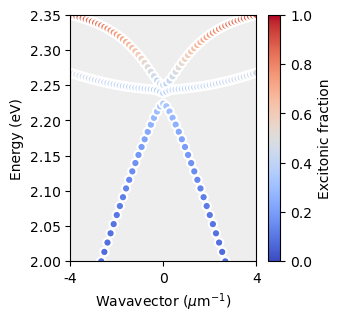

In [14]:
fig, ax = plt.subplots(1, figsize = (3, 3.2))
legume.viz.pol_bands(pol,fraction=True,ax=ax)
ax.set_xticks(path['indexes'])
ax.set_xticklabels([f"{-k_dim_max}","0",f"{k_dim_max}"])
ax.set_xlabel("Wavavector ($\\mu$m$^{-1}$)")
plt.ylim(2.,2.35)